# Finetuning de BERT BASE MULTILINGUAL CASED


// Preparation of labels ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']
-> mapping labels and ids:  {'B-ARR': 0, 'B-DEP': 1, 'I-ARR': 2, 'I-DEP': 3, 'O': 4}

// Starting train data encoding...

---> Ligne 1
- Original sentence:  montre-moi les trains dimanche allant de Jarville-la-Malgrange à La Bassée-Violaines en première classe sans correspondance partant l'après midi
- Encoded tokens:  ['[CLS]', 'montre', '-', 'moi', 'les', 'trains', 'dimanche', 'allant', 'de', 'Jar', '##ville', '-', 'la', '-', 'Mal', '##gra', '##nge', 'à', 'La', 'Bass', '##ée', '-', 'Viola', '##ines', 'en', 'première', 'classe', 'sans', 'correspond', '##ance', 'part', '##ant', 'l', "'", 'après', '[SEP]']
- Labels after encoding the entities:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'I-DEP', 'O', 'B-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'I-ARR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
- Label IDs [4 4 4 4 4 4 4 4 4 1 3 3 3 3 3 

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> model loaded with  5 labels

// Starting model training...
Epoch 1/9
24/24 [==============================] - 107s 3s/step - loss: 0.5007 - accuracy: 0.7996 - val_loss: 0.1932 - val_accuracy: 0.9595
Epoch 2/9
24/24 [==============================] - 68s 3s/step - loss: 0.1618 - accuracy: 0.9569 - val_loss: 0.0529 - val_accuracy: 0.9861
Epoch 3/9
24/24 [==============================] - 71s 3s/step - loss: 0.0947 - accuracy: 0.9720 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 4/9
24/24 [==============================] - 65s 3s/step - loss: 0.0504 - accuracy: 0.9861 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 5/9
24/24 [==============================] - 62s 3s/step - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/9
24/24 [==============================] - 62s 3s/step - loss: 0.0378 - accuracy: 0.9891 - val_loss: 0.0240 - val_accuracy: 0.9977
Epoch 7/9
24/24 [==============================] - 62s 3s/step - loss: 0.0318 - accuracy: 0.9925 - val_

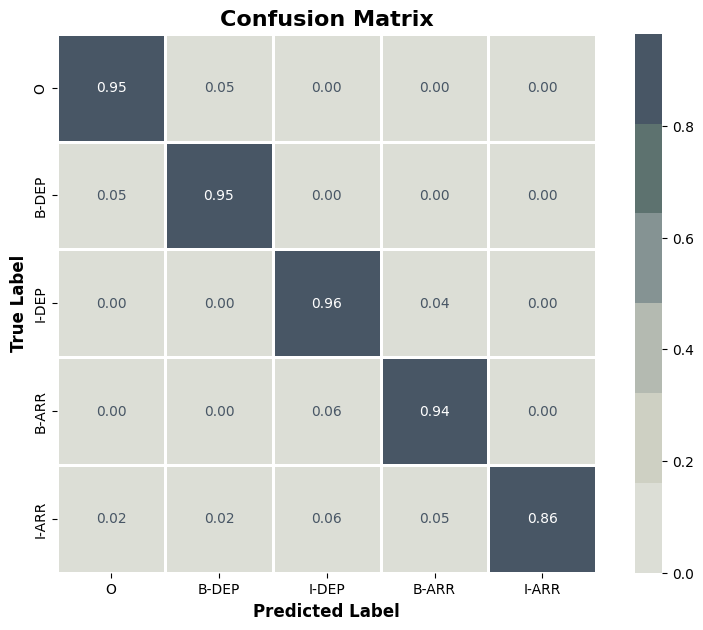


Confusion Matrix:
[[  19    1    0    0    0]
 [   1   21    0    0    0]
 [   0    0   55    2    0]
 [   0    0    5   76    0]
 [  29   28   91   81 1355]]

Classification Report:
              precision    recall  f1-score   support

           O       0.39      0.95      0.55        20
       B-DEP       0.42      0.95      0.58        22
       I-DEP       0.36      0.96      0.53        57
       B-ARR       0.48      0.94      0.63        81
       I-ARR       1.00      0.86      0.92      1584

    accuracy                           0.87      1764
   macro avg       0.53      0.93      0.64      1764
weighted avg       0.94      0.87      0.89      1764


Evolution of accuracy and loss over the epoch:


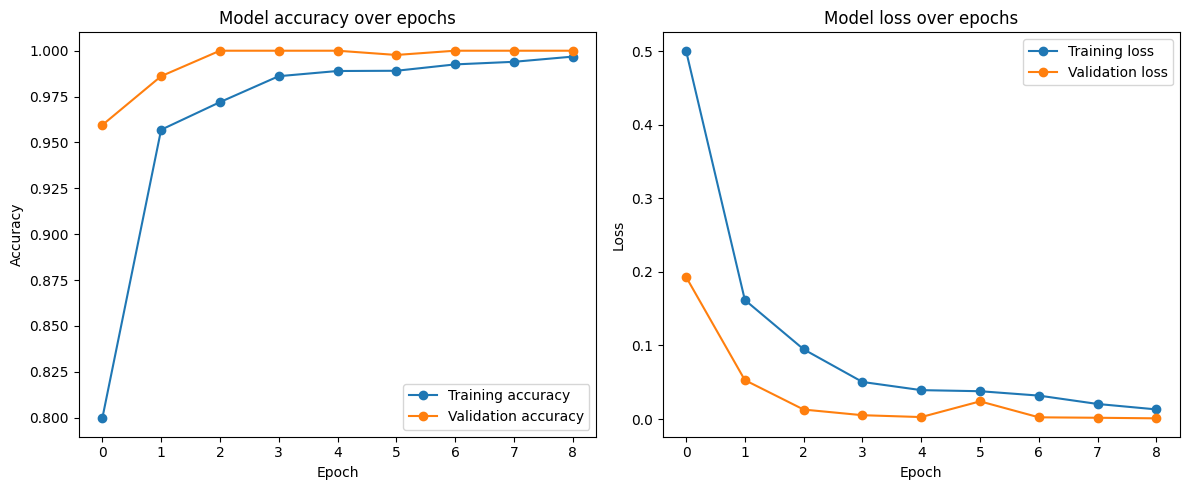


ROC multiclasses curve:


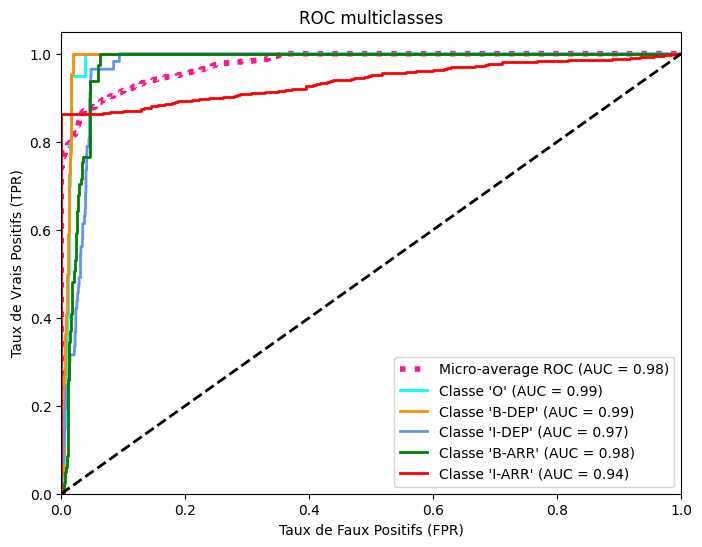

In [1]:
import os
import warnings
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertForTokenClassification
from sklearn.preprocessing import LabelEncoder

from dotenv import load_dotenv
from utils import encode_data, get_ROC_curve, get_metrics

load_dotenv()
huggingface_token = os.environ.get('HUGGINGFACEHUB_API_TOKEN')
if not huggingface_token:
    raise ValueError("HUGGINGFACEHUB_API_TOKEN n'a pas été trouvé -> vérifier le .env")

notebook_dir = os.getcwd()
data_dir = os.path.join(notebook_dir, '..', '..', 'data')
datasets = {file_name: os.path.join(data_dir, file_name) for file_name in os.listdir(data_dir) 
            if os.path.isfile(os.path.join(data_dir, file_name))}

train_path = datasets.get('reservation-first-dataset-train.csv')
test_path = datasets.get('reservation-first-dataset-test.csv')

data_train = pd.read_csv(train_path).fillna('')
data_test = pd.read_csv(test_path).fillna('')


print("\n// Preparation of labels ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']")
unique_labels = ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)
print("-> mapping labels and ids: ", {label: idx for idx, label in enumerate(label_encoder.classes_)})

tokenizer = BertTokenizerFast.from_pretrained('google-bert/bert-base-multilingual-cased')

print("\n// Starting train data encoding...")
train_tokens, train_labels = encode_data(data_train, tokenizer, label_encoder, max_length=36)
print("\n// Starting test data encoding...")
test_tokens, test_labels = encode_data(data_test, tokenizer, label_encoder, max_length=36)

##################
# Model training #
##################

model = TFBertForTokenClassification.from_pretrained(
    'google-bert/bert-base-multilingual-cased', 
    num_labels=len(label_encoder.classes_),
    token=huggingface_token
)
print("-> model loaded with ", len(label_encoder.classes_), "labels")

# configuration
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
print("\n// Starting model training...")
history = model.fit(train_tokens, train_labels, epochs=9, batch_size=9, validation_split=0.1) # training

##############
# Model Save #
##############
model_path = os.path.join(os.getcwd(), '..', '..', 'model', 'models', 'bert-base-multilingual-cased')
absolute_model_path = os.path.abspath(model_path)

model.save_pretrained(absolute_model_path)  # model
tokenizer.save_pretrained(absolute_model_path)  # tokenizer

####################
# Model Evaluation #
####################
evaluation_results = model.evaluate(test_tokens, test_labels)
print("Evaluation results:", evaluation_results)

test_predictions = model.predict(test_tokens).logits
predicted_labels = np.argmax(test_predictions, axis=-1).flatten()
true_labels = test_labels.flatten() 

get_metrics(true_labels=true_labels, predicted_labels=predicted_labels, unique_labels=unique_labels, history=history)

get_ROC_curve(true_labels=test_labels, logits=test_predictions, unique_labels=unique_labels)
